In [1]:
pip install tensorflow

In [2]:
pip install xgboost

In [3]:
pip install imblearn

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [8]:
df_tr = pd.read_csv('fraudTrain.csv')
df_te = pd.read_csv('fraudTest.csv')
df_tr.info()
df_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

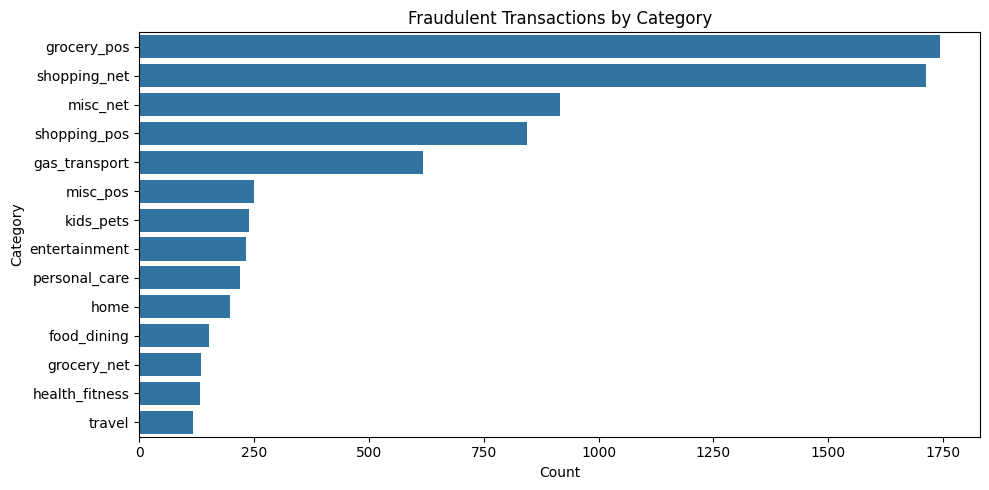

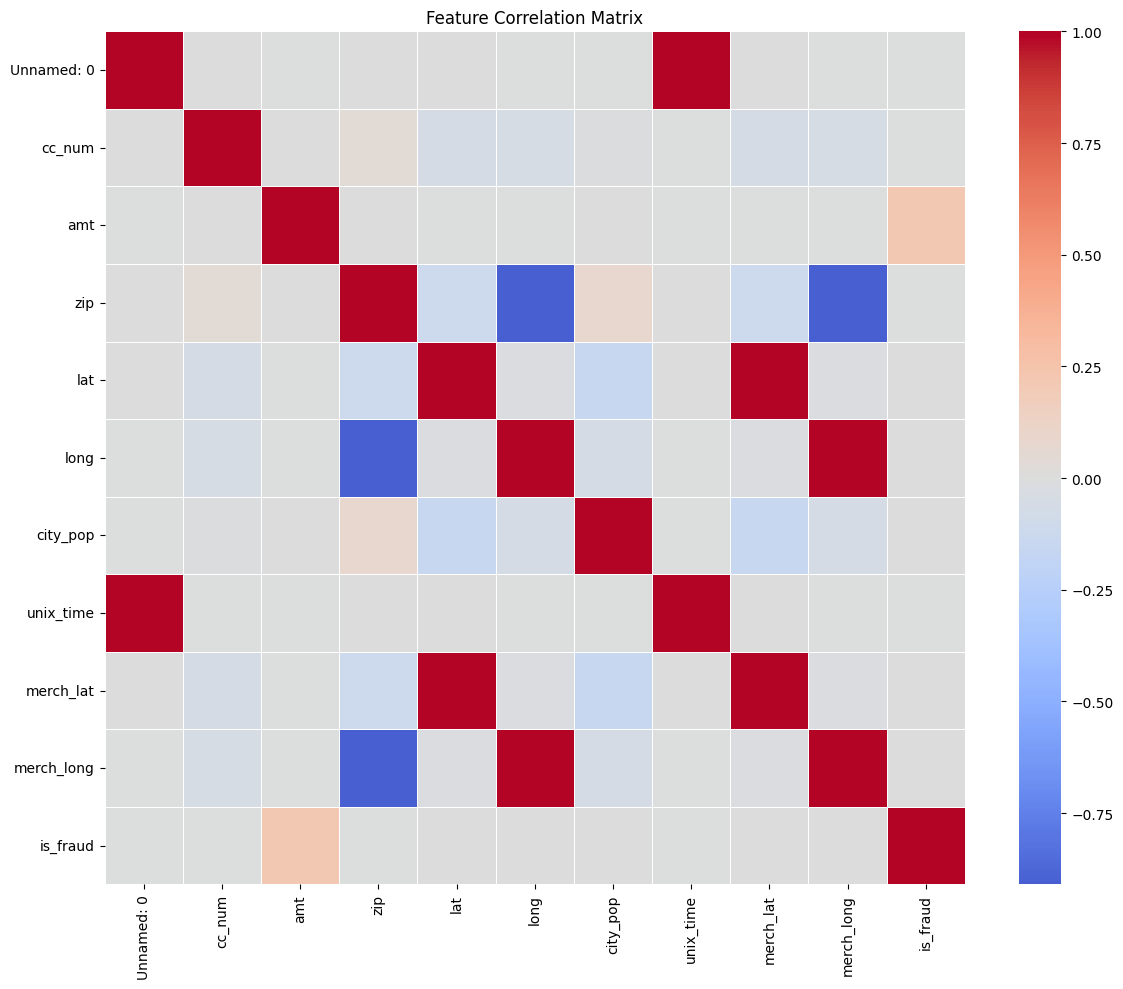

In [10]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define numerical columns for correlation
num_cols = df_tr.select_dtypes(include=[np.number]).columns.tolist()

# Plotly Pie Chart for Class Distribution
counts = df_tr['is_fraud'].value_counts().sort_index()
labels = ['Normal', 'Fraud']
values = [counts.get(0, 0) / counts.sum(), counts.get(1, 0) / counts.sum()]
colors = ['purple', 'red']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.3,
    marker=dict(colors=colors, line=dict(color='white', width=0.1))
)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20)
fig.update_layout(
    title_text="Training Set Class Distribution",
    paper_bgcolor="white",
    plot_bgcolor="white",
    font_color="black"
)
fig.show()

# Quick overview
print(df_tr.info())
print("Missing values in training set:\n", df_tr.isnull().sum())
print("\nMissing values in test set:\n", df_te.isnull().sum())
print("\nClass balance (fraud vs non-fraud):", counts.to_dict())

# Fraud count by category
plt.figure(figsize=(10,5))
sns.countplot(
    y='category',
    data=df_tr[df_tr['is_fraud'] == 1],
    order=df_tr[df_tr['is_fraud'] == 1]['category'].value_counts().index
)
plt.title("Fraudulent Transactions by Category")
plt.ylabel("Category")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Checking Correlations
corr = df_tr[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


# Model 1 (Baseline Logistic Regression Model) & Model 2 (Random Forest with Geolocation Distance Feature)

In [11]:
# ================= FRAUD DETECTION =================
# ------------------------ Utility funcs ------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a)) * R

def best_threshold(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    idx = np.nanargmax(f1)
    return (thr[idx] if idx < len(thr) else 0.5,
            f1[idx], prec[idx], rec[idx])

def eval_and_print(tag, y_true, y_pred, y_proba):
    print(f"\n-- {tag} --")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))

# ------------------------ Load data ------------------------
df_tr = pd.read_csv("fraudTrain.csv")
df_te  = pd.read_csv("fraudTest.csv")

# ------------------------ Feature engineering ------------------------
for df in (df_tr, df_te):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['night_transaction'] = ((df['hour'] >= 21) | (df['hour'] < 6)).astype(int)
    # sin/cos cyclical hour
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['distance_km'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    df['log_amt'] = np.log1p(df['amt'])

# Category & state risk (from train only)
cat_fraud_rate = df_tr.groupby('category')['is_fraud'].mean()
st_fraud_rate  = df_tr.groupby('state')['is_fraud'].mean()
df_tr['category_risk'] = df_tr['category'].map(cat_fraud_rate).fillna(0)
df_te['category_risk'] = df_te['category'].map(cat_fraud_rate).fillna(0)
df_tr['state_risk']    = df_tr['state'].map(st_fraud_rate).fillna(0)
df_te['state_risk']    = df_te['state'].map(st_fraud_rate).fillna(0)

# Per-card (cc_num) behavior features (only using train history)
card_stats = (df_tr.groupby('cc_num')
                .agg(card_txn_count=('cc_num','size'),
                     card_mean_amt=('amt','mean'),
                     card_std_amt=('amt','std'))
                .fillna(0))
df_tr = df_tr.merge(card_stats, on='cc_num', how='left')
df_te = df_te.merge(card_stats, on='cc_num', how='left').fillna(0)

# Final feature list (rich set)
FEATURES = [
    'amt','log_amt','distance_km','night_transaction','hour','day_of_week',
    'hour_sin','hour_cos','category_risk','state_risk',
    'card_txn_count','card_mean_amt','card_std_amt'
]
y_train_full = df_tr['is_fraud'].values
y_test       = df_te['is_fraud'].values
X_train_full = df_tr[FEATURES].values
X_test       = df_te[FEATURES].values

# ------------------------ Time-based split inside TRAIN for threshold tuning ------------------------
# Use earliest 80% of transactions by date for training, latest 20% for validation
df_tr_sorted = df_tr.sort_values('trans_date_trans_time')
cutoff_idx = int(len(df_tr_sorted)*0.8)
train_idx = df_tr_sorted.index[:cutoff_idx]
val_idx   = df_tr_sorted.index[cutoff_idx:]

X_tr, y_tr = X_train_full[train_idx], y_train_full[train_idx]
X_val, y_val = X_train_full[val_idx], y_train_full[val_idx]

# ------------------------ MODEL 1: Logistic Regression (needs scaling + SMOTE) ------------------------
print("\n================= MODEL 1: Logistic Regression (Baseline) =================")
scaler_lr = StandardScaler()
X_tr_lr = scaler_lr.fit_transform(X_tr)
X_val_lr = scaler_lr.transform(X_val)
X_full_lr = scaler_lr.fit_transform(X_train_full)
X_test_lr = scaler_lr.transform(X_test)

sm = SMOTE(random_state=42)
X_tr_lr_res, y_tr_lr_res = sm.fit_resample(X_tr_lr, y_tr)

lr = LogisticRegression(max_iter=2000, class_weight=None, random_state=42, n_jobs=-1)
lr.fit(X_tr_lr_res, y_tr_lr_res)

val_proba = lr.predict_proba(X_val_lr)[:,1]
thr, f1v, pv, rv = best_threshold(y_val, val_proba)
print(f"Chosen threshold (val max F1): {thr:.3f} | F1={f1v:.4f} P={pv:.4f} R={rv:.4f}")

# Fit on full train (resampled)
X_full_lr_res, y_full_lr_res = sm.fit_resample(X_full_lr, y_train_full)
lr.fit(X_full_lr_res, y_full_lr_res)

# Train metrics (original train distribution)
train_proba = lr.predict_proba(X_full_lr)[:,1]
train_pred  = (train_proba >= thr).astype(int)
eval_and_print("Model 1 TRAIN", y_train_full, train_pred, train_proba)

# Test metrics
test_proba = lr.predict_proba(X_test_lr)[:,1]
test_pred  = (test_proba >= thr).astype(int)
eval_and_print("Model 1 TEST", y_test, test_pred, test_proba)

# ------------------------ MODEL 2: Random Forest (class_weight, no SMOTE) ------------------------
print("\n================= MODEL 2: Random Forest (Distance Focus + core feats) =================")
# We'll use fewer features to keep it "distance-focused" but still useful
FEAT_M2 = ['amt','distance_km','night_transaction','hour_sin','hour_cos','category_risk']
X_train_full_m2 = df_tr[FEAT_M2].values
X_test_m2       = df_te[FEAT_M2].values
X_tr_m2, X_val_m2 = X_train_full_m2[train_idx], X_train_full_m2[val_idx]

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    class_weight='balanced',   # handle imbalance instead of SMOTE
    n_jobs=-1,
    random_state=42
)
rf.fit(X_tr_m2, y_tr)

val_proba = rf.predict_proba(X_val_m2)[:,1]
thr, f1v, pv, rv = best_threshold(y_val, val_proba)
print(f"Chosen threshold (val max F1): {thr:.3f} | F1={f1v:.4f} P={pv:.4f} R={rv:.4f}")

# Train metrics
train_proba = rf.predict_proba(X_train_full_m2)[:,1]
train_pred  = (train_proba >= thr).astype(int)
eval_and_print("Model 2 TRAIN", y_train_full, train_pred, train_proba)

# Test metrics
test_proba = rf.predict_proba(X_test_m2)[:,1]
test_pred  = (test_proba >= thr).astype(int)
eval_and_print("Model 2 TEST", y_test, test_pred, test_proba)


================= MODEL 1: Logistic Regression (Baseline) =================
Chosen threshold (val max F1): 0.994 | F1=0.4577 P=0.4495 R=0.4662

-- Model 1 TRAIN --
Confusion Matrix:
 [[1284954    4215]
 [   4073    3433]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9968    0.9967    0.9968   1289169
           1     0.4489    0.4574    0.4531      7506

    accuracy                         0.9936   1296675
   macro avg     0.7229    0.7270    0.7249   1296675
weighted avg     0.9937    0.9936    0.9936   1296675

ROC AUC: 0.944915336896899

-- Model 1 TEST --
Confusion Matrix:
 [[551769   1805]
 [  1246    899]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9977    0.9967    0.9972    553574
           1     0.3325    0.4191    0.3708      2145

    accuracy                         0.9945    555719
   macro avg     0.6651    0.7079    0.6840    555719
weighted avg     0.9952    

## Model 3 (XGBoost with Category Risk Encoding)

In [12]:
# ---------------- Helpers ----------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def eval_block(title, y_true, y_pred, y_proba):
    print(f"\n-- {title} --")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))

# -------- Load --------
df_tr = pd.read_csv("fraudTrain.csv")
df_te  = pd.read_csv("fraudTest.csv")

# -------- Basic FE --------
for df in (df_tr, df_te):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour']   = df['trans_date_trans_time'].dt.hour
    df['dow']    = df['trans_date_trans_time'].dt.dayofweek
    df['night']  = ((df['hour'] >= 21) | (df['hour'] < 6)).astype(int)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['distance_km'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    df['log_amt'] = np.log1p(df['amt'])
    df['is_online'] = df['category'].str.endswith('_net').astype(int)

# Risk encodings (train only)
cat_rate   = df_tr.groupby('category')['is_fraud'].mean()
state_rate = df_tr.groupby('state')['is_fraud'].mean()
merch_rate = df_tr.groupby('merchant')['is_fraud'].mean()

for df in (df_tr, df_te):
    df['category_risk'] = df['category'].map(cat_rate).fillna(0)
    df['state_risk']    = df['state'].map(state_rate).fillna(0)
    df['merchant_risk'] = df['merchant'].map(merch_rate).fillna(0)

# Per-card aggregates (train only)
card_stats = (df_tr.groupby('cc_num')
              .agg(card_txn_cnt=('cc_num','size'),
                   card_mean_amt=('amt','mean'),
                   card_std_amt=('amt','std'))
              .fillna(0))
df_tr = df_tr.merge(card_stats, on='cc_num', how='left')
df_te = df_te.merge(card_stats, on='cc_num', how='left').fillna(0)

# Amount relative to card history
df_tr['amt_z_card'] = (df_tr['amt'] - df_tr['card_mean_amt'])/(df_tr['card_std_amt']+1e-6)
df_te['amt_z_card'] = (df_te['amt'] - df_te['card_mean_amt'])/(df_te['card_std_amt']+1e-6)
df_tr['amt_over_mean_card'] = df_tr['amt']/(df_tr['card_mean_amt']+1e-6)
df_te['amt_over_mean_card'] = df_te['amt']/(df_te['card_mean_amt']+1e-6)

# Rolling velocity features (last 24h, 7d) within TRAIN only to avoid leakage
df_tr = df_tr.sort_values(['cc_num','trans_date_trans_time'])
for window, colname in [(1, 'txns_24h'), (7, 'txns_7d')]:
    counts = []
    grp = df_tr.groupby('cc_num')
    for _, g in grp:
        times = g['trans_date_trans_time'].values
        idxs = g.index
        arr = np.zeros(len(g), dtype=int)
        for i in range(len(g)):
            cutoff = times[i] - np.timedelta64(window, 'D')
            arr[i] = np.sum((times > cutoff) & (times <= times[i]))
        counts.extend(arr)
    df_tr[colname] = counts

# For TEST, approximate velocity using training history only (no leakage)
df_te = df_te.sort_values(['cc_num','trans_date_trans_time'])
df_te['txns_24h'] = 0
df_te['txns_7d']  = 0
# Build a dict of past txn times from train
hist_times = df_tr.groupby('cc_num')['trans_date_trans_time'].apply(list).to_dict()
for i, row in df_te.iterrows():
    cc = row['cc_num']
    t  = row['trans_date_trans_time']
    past = hist_times.get(cc, [])
    if past:
        past_arr = np.array(past)
        df_te.at[i,'txns_24h'] = np.sum((past_arr > t - np.timedelta64(1,'D')) & (past_arr <= t))
        df_te.at[i,'txns_7d']  = np.sum((past_arr > t - np.timedelta64(7,'D')) & (past_arr <= t))

# Interaction terms
for df in (df_tr, df_te):
    df['amt_x_catRisk']   = df['amt'] * df['category_risk']
    df['dist_x_online']   = df['distance_km'] * df['is_online']
    df['amt_x_night']     = df['amt'] * df['night']

# Final features
FEATURES = [
    'amt','log_amt','distance_km','night','hour_sin','hour_cos','dow','is_online',
    'category_risk','state_risk','merchant_risk',
    'card_txn_cnt','card_mean_amt','card_std_amt',
    'amt_z_card','amt_over_mean_card',
    'txns_24h','txns_7d',
    'amt_x_catRisk','dist_x_online','amt_x_night'
]

X_train_full = df_tr[FEATURES].values
y_train_full = df_tr['is_fraud'].values
X_test_full  = df_te[FEATURES].values
y_test       = df_te['is_fraud'].values

# Time split (80/20)
df_tr_sorted = df_tr.sort_values('trans_date_trans_time')
cut = int(len(df_tr_sorted)*0.8)
train_idx = df_tr_sorted.index[:cut]
val_idx   = df_tr_sorted.index[cut:]

X_tr, y_tr = X_train_full[train_idx], y_train_full[train_idx]
X_val, y_val = X_train_full[val_idx], y_train_full[val_idx]


# ---------- Model 3: XGBoost (threshold=0.5, heavier pos weight) ----------
print("\n================= MODEL 3: XGBoost (threshold=0.5) =================")
ratio = (len(y_tr)-y_tr.sum())/(y_tr.sum()+1e-6)
xgb = XGBClassifier(
    n_estimators=1400,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=2,
    subsample=0.9,
    colsample_bytree=0.85,
    gamma=0.3,
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=ratio*1.5,  # heavier to push fraud probs up
    max_delta_step=2,            # stabilize updates for imbalanced data
    eval_metric='aucpr',
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_tr, y_tr)

train_proba = xgb.predict_proba(X_train_full)[:,1]
train_pred  = (train_proba >= 0.5).astype(int)
eval_block("Model 3 TRAIN", y_train_full, train_pred, train_proba)

test_proba = xgb.predict_proba(X_test_full)[:,1]
test_pred  = (test_proba >= 0.5).astype(int)
eval_block("Model 3 TEST", y_test, test_pred, test_proba)


================= MODEL 3: XGBoost (threshold=0.5) =================

-- Model 3 TRAIN --
Confusion Matrix:
 [[1287056    2113]
 [    142    7364]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9984    0.9991   1289169
           1     0.7770    0.9811    0.8672      7506

    accuracy                         0.9983   1296675
   macro avg     0.8885    0.9897    0.9332   1296675
weighted avg     0.9986    0.9983    0.9984   1296675

ROC AUC: 0.9994466023759873

-- Model 3 TEST --
Confusion Matrix:
 [[553327    247]
 [   742   1403]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9987    0.9996    0.9991    553574
           1     0.8503    0.6541    0.7394      2145

    accuracy                         0.9982    555719
   macro avg     0.9245    0.8268    0.8693    555719
weighted avg     0.9981    0.9982    0.9981    555719

ROC AUC: 0.9848814282250462


## Model 4 (Random Forest with Merchant Risk & Transaction Velocity)

In [13]:
# --- 1) Haversine distance ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# --- 2) Load data (adjust paths if needed) ---
df_tr = pd.read_csv("fraudTrain.csv")
df_te = pd.read_csv("fraudTest.csv")

# --- 3) Feature engineering ---
for df in (df_tr, df_te):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour']     = df['trans_date_trans_time'].dt.hour
    df['dow']      = df['trans_date_trans_time'].dt.dayofweek
    df['night']    = ((df['hour'] >= 21) | (df['hour'] < 6)).astype(int)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['distance_km'] = haversine(
        df['lat'], df['long'],
        df['merch_lat'], df['merch_long']
    )
    df['log_amt']   = np.log1p(df['amt'])
    df['is_online'] = df['category'].str.endswith('_net').astype(int)

# --- 4) Risk encodings (train-only) ---
for col in ['category','state','merchant']:
    rate = df_tr.groupby(col)['is_fraud'].mean()
    df_tr[f'{col}_risk'] = df_tr[col].map(rate).fillna(0)
    df_te[f'{col}_risk'] = df_te[col].map(rate).fillna(0)

# --- 5) Card-level aggregates ---
card_stats = df_tr.groupby('cc_num').agg(
    card_txn_cnt=('cc_num','size'),
    card_mean_amt=('amt','mean'),
    card_std_amt=('amt','std')
).fillna(0)
df_tr = df_tr.merge(card_stats, on='cc_num', how='left')
df_te = df_te.merge(card_stats, on='cc_num', how='left').fillna(0)

# --- 6) Transaction velocity from TRAIN history ---
hist = df_tr.groupby('cc_num')['trans_date_trans_time'].apply(list).to_dict()
df_tr = df_tr.sort_values(['cc_num','trans_date_trans_time'])
vel24, vel7 = [], []
for cc, times in hist.items():
    arr = np.array(times, dtype='datetime64[ns]')
    vel24.extend([np.sum((arr > t - np.timedelta64(1,'D')) & (arr <= t)) for t in arr])
    vel7.extend([np.sum((arr > t - np.timedelta64(7,'D')) & (arr <= t)) for t in arr])
df_tr['txns_24h'], df_tr['txns_7d'] = vel24, vel7

# Approximate for TEST
df_te['txns_24h'] = df_te['txns_7d'] = 0
for idx, row in df_te.iterrows():
    t   = np.datetime64(row['trans_date_trans_time'])
    arr = np.array(hist.get(row['cc_num'], []), dtype='datetime64[ns]')
    if arr.size:
        df_te.at[idx,'txns_24h'] = np.sum((arr > t - np.timedelta64(1,'D')) & (arr <= t))
        df_te.at[idx,'txns_7d']  = np.sum((arr > t - np.timedelta64(7,'D')) & (arr <= t))

# --- 7) Interaction features ---
for df in (df_tr, df_te):
    df['amt_x_catRisk']  = df['amt'] * df['category_risk']
    df['dist_x_online']  = df['distance_km'] * df['is_online']

# --- 8) Feature list & arrays ---
FEATURES4 = [
    'amt','log_amt','distance_km','night','hour_sin','hour_cos','dow','is_online',
    'category_risk','state_risk','merchant_risk',
    'card_txn_cnt','card_mean_amt','card_std_amt',
    'txns_24h','txns_7d',
    'amt_x_catRisk','dist_x_online'
]
X4      = df_tr[FEATURES4].values; y4      = df_tr['is_fraud'].values
X4_test = df_te[FEATURES4].values; y4_test = df_te['is_fraud'].values

# --- 9) Train/validation split ---
X4_tr, X4_val, y4_tr, y4_val = train_test_split(
    X4, y4, test_size=0.2, stratify=y4, random_state=42
)

# ---10) Scale features ---
scaler4    = StandardScaler()
X4_tr_sc   = scaler4.fit_transform(X4_tr)
X4_val_sc  = scaler4.transform(X4_val)
X4_full_sc = scaler4.fit_transform(X4)
X4_test_sc = scaler4.transform(X4_test)

# ---11) Train RandomForest with class_weight ---
rf4 = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf4.fit(X4_tr_sc, y4_tr)

# ---12) Evaluate on TRAIN ---
y4_tr_pred   = rf4.predict(X4_full_sc)
y4_tr_proba  = rf4.predict_proba(X4_full_sc)[:,1]
print("\n-- Model 4 TRAIN --")
print(confusion_matrix(y4, y4_tr_pred))
print(classification_report(y4, y4_tr_pred, digits=4))
print("ROC AUC:", roc_auc_score(y4, y4_tr_proba))

# ---13) Evaluate on TEST (threshold=0.5) ---
y4_te_pred   = rf4.predict(X4_test_sc)
y4_te_proba  = rf4.predict_proba(X4_test_sc)[:,1]
print("\n-- Model 4 TEST --")
print(confusion_matrix(y4_test, y4_te_pred))
print(classification_report(y4_test, y4_te_pred, digits=4))
print("ROC AUC:", roc_auc_score(y4_test, y4_te_proba))



-- Model 4 TRAIN --
[[1288015    1154]
 [    500    7006]]
              precision    recall  f1-score   support

           0     0.9996    0.9991    0.9994   1289169
           1     0.8586    0.9334    0.8944      7506

    accuracy                         0.9987   1296675
   macro avg     0.9291    0.9662    0.9469   1296675
weighted avg     0.9988    0.9987    0.9988   1296675

ROC AUC: 0.9994495975697526

-- Model 4 TEST --
[[553160    414]
 [   626   1519]]
              precision    recall  f1-score   support

           0     0.9989    0.9993    0.9991    553574
           1     0.7858    0.7082    0.7450      2145

    accuracy                         0.9981    555719
   macro avg     0.8923    0.8537    0.8720    555719
weighted avg     0.9980    0.9981    0.9981    555719

ROC AUC: 0.9896711981105394
